In [1]:
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score





In [2]:
data = pd.read_csv("data/first_round_raw.csv")

In [3]:

def get_metrics(y_test, y_pred):
    predicted_for_discharge = list(np.where(y_pred == False)[0])
    wrongful_discharge = y_test.reset_index(drop=True)[predicted_for_discharge].sum()/len(predicted_for_discharge)
    print(f"WRONGFUL DISCHARGE RATE: {wrongful_discharge}")

    print(f"F1_SCORE: {f1_score(y_test, y_pred)}")
    print(f"RECALL: {recall_score(y_test, y_pred)}")
    print(f"PRECISION: {precision_score(y_test, y_pred)}")

    

    try:
        print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
    except: "ROC AUC curve could not be calculated"

In [4]:
get_metrics(data.dropna().true_class, data.dropna().proba>0.5)

WRONGFUL DISCHARGE RATE: 0.07302752293577981
F1_SCORE: 0.26197604790419166
RECALL: 0.6375227686703097
PRECISION: 0.16486104569006124
ROC AUC: 0.6125506376498793


In [5]:
data.dropna().true_class.sum()/len(data.dropna())

0.11324257425742575

In [6]:
valid_columns = [
        "admission_id",
        "patient_id",
        "race",
        "gender",
        "age",
        "weight",
        "admission_type_code",
        "discharge_disposition_code",
        "admission_source_code",
        "time_in_hospital",
        "payer_code",
        "medical_specialty",
        "has_prosthesis",
        "complete_vaccination_status",
        "num_lab_procedures",
        "num_procedures",
        "num_medications",
        "number_outpatient",
        "number_emergency",
        "number_inpatient",
        "diag_1",
        "diag_2",
        "diag_3",
        "number_diagnoses",
        "blood_type",
        "hemoglobin_level",
        "blood_transfusion",
        "max_glu_serum",
        "A1Cresult",
        "diuretics",
        "insulin",
        "change",
        "diabetesMed",
        "readmitted_proba",
        "true_class"
]

In [7]:
rows = []
for row, proba, true_class in zip(data.observation, data.proba, data.true_class):
    row = json.loads(row)
    row["readmitted_proba"] = proba
    row["true_class"] = true_class
    rows.append([row[column] for column in valid_columns])


In [8]:
df = pd.DataFrame(rows, columns = valid_columns)

In [9]:
df["has_prosthesis"] = df["has_prosthesis"].astype(bool)
df["blood_transfusion"] = df["blood_transfusion"].astype(bool)

df["readmitted"] = df["true_class"].replace([1, 0], ["Yes", "No"])
df["readmitted"].unique()

df.to_csv("data/first_round.csv", index=False)

[0.50144964]
[0.16828389]
[0.62966805]
[0.2655874]


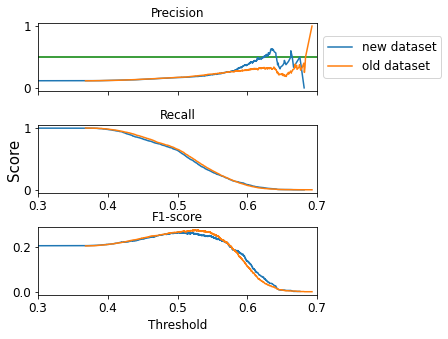

In [10]:
thresholds_old = pd.read_csv("data/rfc_threshold_plot.csv")

precision, recall, thresholds = precision_recall_curve(df.dropna().true_class, df.dropna().readmitted_proba)

precision = precision[:-1]
recall = recall[:-1]
f1_score_result = 2*precision*recall/(precision+recall)


fig = plt.figure(figsize=(5, 5))

ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
ax1.hlines(y=0.5,xmin=0.3, xmax=0.7, colors='green')
ax1.plot(thresholds,precision, label="new dataset")
ax1.plot(thresholds_old.threshold,thresholds_old.precision, label = "old dataset")
ax2.plot(thresholds,recall)
ax2.plot(thresholds_old.threshold,thresholds_old.recall)
ax3.plot(thresholds,f1_score_result)
ax3.plot(thresholds_old.threshold,thresholds_old["f1-score"])

ax1.get_shared_x_axes().join(ax1, ax2, ax3)
ax1.set_xticklabels([])
plt.xlabel('Threshold', size=12)
ax1.set_title('Precision', size=12)
ax2.set_title('Recall', size=12)
ax3.set_title('F1-score', size=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

ax1.set_xlim(0.3, 0.7)
plt.subplots_adjust(hspace=0.5)
fig.text(0.06, 0.5, 'Score', ha='center', va='center', rotation='vertical', size=15)


print(thresholds[np.where(f1_score_result==max(f1_score_result))])
print(precision[np.where(f1_score_result==max(f1_score_result))])
print(recall[np.where(f1_score_result==max(f1_score_result))])
print(f1_score_result[np.where(f1_score_result==max(f1_score_result))])

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)


plt.show()
#fig.savefig(f'new_data_threshold.png', dpi=300, transparent=True, bbox_inches='tight')



In [11]:
for column in ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'hemoglobin_level']:
       print(column)
       print(max(df[column]))
       print(min(df[column]))
       print("XXXXXXX")

time_in_hospital
14.0
1.0
XXXXXXX
num_lab_procedures
111.0
1.0
XXXXXXX
num_procedures
6.0
0.0
XXXXXXX
num_medications
79.0
1.0
XXXXXXX
number_outpatient
21.0
0.0
XXXXXXX
number_emergency
63.0
0.0
XXXXXXX
number_inpatient
16.0
0.0
XXXXXXX
number_diagnoses
16.0
1.0
XXXXXXX
hemoglobin_level
18.0
10.9
XXXXXXX


In [12]:
len(df.drop(["weight", "payer_code", "medical_specialty"], axis=1).dropna())/len(df)

0.8860354785478548